*** The Lending Club: Loan default prediction ***

*MLND Capstone Project Notebook*

**II. Analysis **

*Data Exploration*

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from sklearn import tree
%matplotlib inline

In [40]:
#df = pd.read_csv('loan.csv', na_values=['NA'], nrows=10000)
df = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/loan.csv', na_values=['NA'])

half_count = len(df) / 2
df = df.dropna(thresh=half_count, axis=1) # Drop any column with more than 50% missing values

#print (df.columns)
print (df.describe())
print (df['loan_status'].unique())

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


                 id     member_id      loan_amnt    funded_amnt  \
count  8.873790e+05  8.873790e+05  887379.000000  887379.000000   
mean   3.246513e+07  3.500182e+07   14755.264605   14741.877625   
std    2.282734e+07  2.411335e+07    8435.455601    8429.897657   
min    5.473400e+04  7.047300e+04     500.000000     500.000000   
25%    9.206643e+06  1.087713e+07    8000.000000    8000.000000   
50%    3.443327e+07  3.709528e+07   13000.000000   13000.000000   
75%    5.490814e+07  5.847135e+07   20000.000000   20000.000000   
max    6.861706e+07  7.354484e+07   35000.000000   35000.000000   

       funded_amnt_inv       int_rate    installment    annual_inc  \
count    887379.000000  887379.000000  887379.000000  8.873750e+05   
mean      14702.464383      13.246740     436.717127  7.502759e+04   
std        8442.106732       4.381867     244.186593  6.469830e+04   
min           0.000000       5.320000      15.670000  0.000000e+00   
25%        8000.000000       9.990000     260.

In [41]:
df.issue_d.value_counts()

Oct-2015    48631
Jul-2015    45962
Dec-2015    44342
Oct-2014    38782
Nov-2015    37530
Aug-2015    35886
Apr-2015    35427
Jan-2015    35107
May-2015    31913
Jul-2014    29306
Sep-2015    28641
Jun-2015    28485
Mar-2015    25400
Nov-2014    25054
Feb-2015    23770
May-2014    19099
Apr-2014    19071
Aug-2014    18814
Jun-2014    17179
Mar-2014    16513
Jan-2014    15628
Feb-2014    15269
Dec-2013    15020
Nov-2013    14676
Oct-2013    14114
Sep-2013    12987
Aug-2013    12674
Jul-2013    11910
Jun-2013    10899
Sep-2014    10606
            ...  
Dec-2009      658
Oct-2009      604
Sep-2009      507
Aug-2009      446
Jul-2009      411
Jun-2009      406
Mar-2008      402
May-2009      359
Apr-2009      333
Mar-2009      324
Feb-2008      306
Jan-2008      305
Feb-2009      302
Jan-2009      269
Apr-2008      259
Dec-2008      253
Nov-2008      209
Dec-2007      172
Jul-2008      141
Jun-2008      124
Oct-2008      122
May-2008      115
Nov-2007      112
Oct-2007      105
Aug-2008  

In [ ]:
# How many null descriptions
print ("How many null descriptions? {}".format(len(df[df['desc'].isnull()])))

# Average length of non null descriptions
print ("Average length of Description Text {}".format(df['desc'].dropna().str.len().mean()))

sns.distplot(df['desc'].dropna().str.len())

In [4]:
print ("Number of records {}".format(len(df)))
print ("Dataset Shape {}".format(df.shape))

#df.head(5)
for c in df.columns:
    print (c)

Number of records 887379
Dataset Shape (887379, 53)
id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim


In [5]:
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.describe()

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,887379.0,887350.000000,8.171030e+05,8.171030e+05,8.171030e+05
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,0.396692,45.919243,4.880757,2164.145585,0.014380,1.0,0.004991,2.257026e+02,1.394582e+05,3.206862e+04
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,4.087825,409.693874,63.125281,4794.783233,0.134191,0.0,0.077625,1.031137e+04,1.537500e+05,3.749826e+04
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,NaN,11.910000,NaN,...,0.000000,0.000000,0.000000,280.170000,NaN,1.0,NaN,NaN,NaN,NaN
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,NaN,17.650000,NaN,...,0.000000,0.000000,0.000000,462.780000,NaN,1.0,NaN,NaN,NaN,NaN
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,NaN,23.950000,NaN,...,0.000000,0.000000,0.000000,831.245000,NaN,1.0,NaN,NaN,NaN,NaN
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,358.680000,33520.270000,7002.190000,36475.590000,20.000000,1.0,14.000000,9.152545e+06,8.000078e+06,9.999999e+06


In [6]:
corr = numeric_features.corr()

print (corr['loan_amnt'].sort_values(ascending=False)[:10], '\n')
print (corr['loan_amnt'].sort_values(ascending=False)[-10:])

loan_amnt          1.000000
funded_amnt        0.999263
funded_amnt_inv    0.997115
installment        0.944977
out_prncp_inv      0.646898
out_prncp          0.646897
total_rec_int      0.533916
total_pymnt_inv    0.475655
total_pymnt        0.474626
total_rec_prncp    0.390473
Name: loan_amnt, dtype: float64 

collection_recovery_fee       0.052205
total_rec_late_fee            0.031395
dti                           0.020675
acc_now_delinq                0.003947
delinq_2yrs                  -0.000159
tot_coll_amt                 -0.004275
collections_12_mths_ex_med   -0.016650
inq_last_6mths               -0.034168
pub_rec                      -0.081177
policy_code                        NaN
Name: loan_amnt, dtype: float64


In [7]:
categoricals = df.select_dtypes(exclude=[np.number])
categoricals.describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,887379,887379,887379,835922,887379,887379,887379,887379,887379,887379,...,887379,887228,887379,887379,887350,887379,869720,634408,887326,887379
unique,2,7,35,299272,12,6,3,103,10,2,...,14,63145,935,51,697,2,98,100,103,2
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Source Verified,Oct-2015,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
freq,621125,254535,56323,13469,291569,443557,329558,48631,601779,887369,...,524215,414001,9770,129517,6659,456848,470150,553406,730574,886868


In [8]:
data_dictionary = pd.read_excel('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/LCDataDictionary.xlsx')

print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())

data_dictionary.rename(columns={'LoanStatNew': 'name',
                                'Description': 'description'})
data_dictionary

80
['LoanStatNew', 'Description']


,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


*Exploratory Visualization*

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_



In [37]:
df.term.value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [ ]:
post_loan_features= ['open_acc_6m','open_il_6m','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util',\
    'open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl',\
    'inq_last_12m','acc_now_delinq','tot_coll_amt','tot_cur_bal']

df[post_loan_features].describe()
df.drop(post_loan_features, axis=1)

In [ ]:
sns.pairplot(df[['loan_amnt', 'annual_inc', 'emp_length', \
                  'dti', 'grade', 'loan_status']].dropna(), hue='grade')
plt.set_xticklabels(rotation=30)

In [ ]:
g = sns.factorplot(x="grade", y="loan_amnt", hue="isDefault", order=["A","B","C","D","E","F","G"], data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)

g2 = sns.factorplot(x="purpose", y="loan_amnt", hue="isDefault", data=df, size=6, \
                    kind="violin", split=True, cut=1, aspect=1)
g2.set_xticklabels(rotation=90)

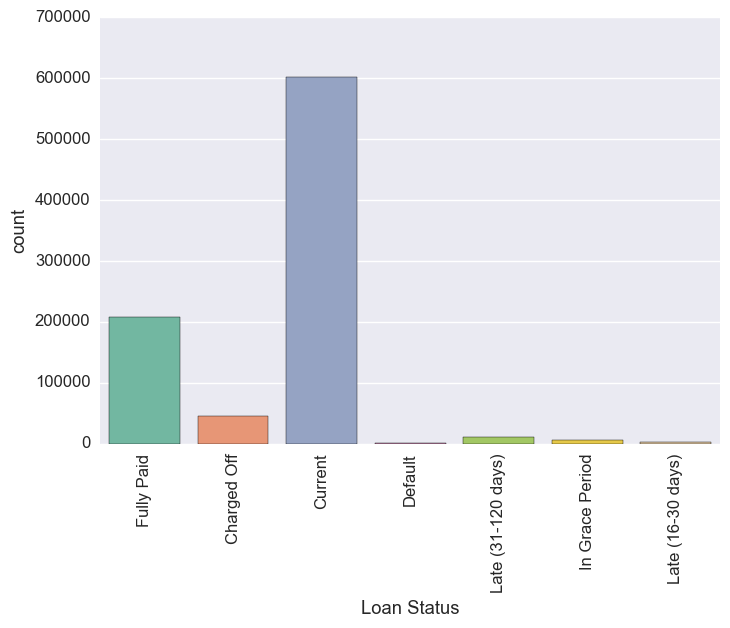

In [316]:
plt.xticks(rotation=90)

df_status = df.loc[df['loan_status'].isin(['Current','Charged Off','Default','Fully Paid','In Grace Period','Late (16-30 days)','Late (31-120 days)'])]

sns.countplot(df_status['loan_status'], palette='Set2')
plt.xlabel('Loan Status')

In [42]:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


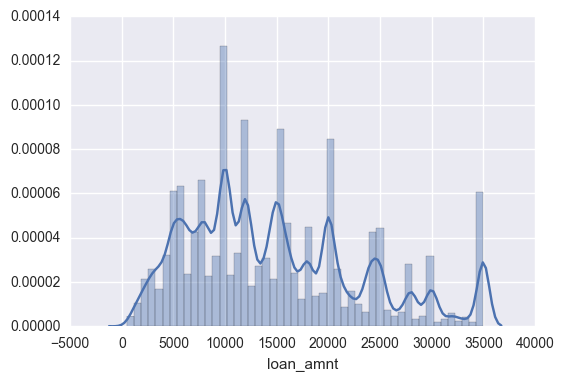

In [12]:
sns.distplot(df['loan_amnt'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

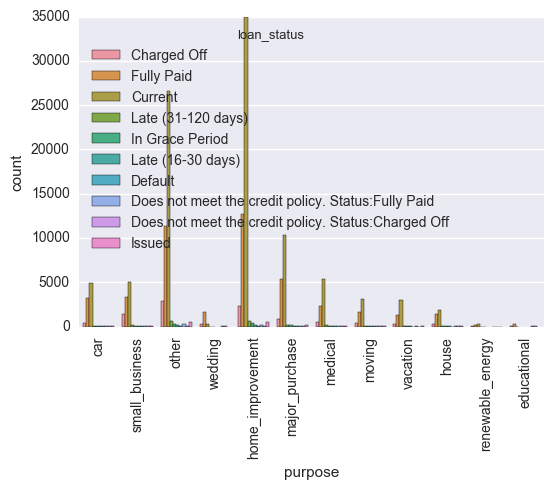

In [13]:
df_sub = df[df.purpose.isin(['debt_consolidation', 'credit_card']) == False]
sns.countplot(x="purpose", hue="loan_status", data=df_sub)
plt.xticks(rotation=90)

In [14]:
df[df.purpose.isin(['debt_consolidation', 'credit_card']) == False].groupby(by=['loan_status','purpose']).count()['id']

loan_status         purpose         
Charged Off         car                   448
                    educational            56
                    home_improvement     2269
                    house                 286
                    major_purchase        874
                    medical               569
                    moving                425
                    other                2936
                    renewable_energy       54
                    small_business       1371
                    vacation              270
                    wedding               265
Current             car                  4937
                    educational             1
                    home_improvement    34980
                    house                1854
                    major_purchase      10308
                    medical              5324
                    moving               3121
                    other               26607
                    renewable_energy      2

In [ ]:
plt.xticks(rotation=90)
sns.stripplot(data=df[['loan_status','loan_amnt', 'purpose']], x='purpose', y='loan_amnt', \
              jitter=True, hue='loan_status', split=True)

In [ ]:
#p1 = sns.violinplot(data=df[['loan_status', 'int_rate', 'grade', 'loan_amnt']], hue='loan_status', x='grade', \
#               order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], y='loan_amnt', split=True, inner='quartile')
mapping_dict = {'loan_status':{1:'Fully Paid', 0:'Default'}}
df = df.replace(mapping_dict)

p2 = sns.violinplot(data=df[['loan_status', 'int_rate', 'grade']], hue='loan_status', x='grade', \
               order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], y='int_rate', split=True, inner='quartile')

plt.xticks(rotation=0)

In [ ]:
plot_df = df.query('loan_amnt > 10 & int_rate <28')[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5}) 

g = sns.lmplot("int_rate", "loan_amnt", x_jitter= .7,  y_jitter= .1,
           data=plot_df, hue='term',lowess=True, size=5,aspect=1.4, legend_out=False,
           scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(2.5, 28),ylim=(580, 880),alpha = .5)

#g.savefig('1.png',transparent=True)

In [ ]:
plot_df.head()

# Data Preprocessing

** Cleaning abnomalies **

Converting data format and type for some features:

Employment Length

In [43]:
def print_data_shape(df):
    print ("No rows: {}".format(df.shape[0]))
    print ("No cols: {}".format(df.shape[1]))
    print (df.head(1).values)
    print ("Columns: " + df.columns)
    #df.info()

In [44]:
df.replace('n/a', np.nan,inplace=True)
df.emp_length.fillna(value=0,inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['emp_length'] = df['emp_length'].astype(int)
#df.emp_length.head()
print_data_shape(df)

No rows: 887379
No cols: 53
[[1077501 1296599 5000.0 5000.0 4975.0 ' 36 months' 10.65 162.87 'B' 'B2'
  nan 10 'RENT' 24000.0 'Verified' 'Dec-2011' 'Fully Paid' 'n'
  'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501'
  'credit_card' 'Computer' '860xx' 'AZ' 27.65 0.0 'Jan-1985' 1.0 3.0 0.0
  13648.0 83.7 9.0 'f' 0.0 0.0 5861.07141425 5831.78 5000.0 861.07 0.0 0.0
  0.0 'Jan-2015' 171.62 nan 'Jan-2016' 0.0 1.0 'INDIVIDUAL' 0.0 nan nan nan]]
Index(['Columns: id', 'Columns: member_id', 'Columns: loan_amnt',
       'Columns: funded_amnt', 'Columns: funded_amnt_inv', 'Columns: term',
       'Columns: int_rate', 'Columns: installment', 'Columns: grade',
       'Columns: sub_grade', 'Columns: emp_title', 'Columns: emp_length',
       'Columns: home_ownership', 'Columns: annual_inc',
       'Columns: verification_status', 'Columns: issue_d',
       'Columns: loan_status', 'Columns: pymnt_plan', 'Columns: url',
       'Columns: purpose', 'Columns: title', 'Columns: zip_code'

interest rate

In [ ]:
#numeric_features.columns
categoricals.columns

#df.int_rate.head(10)
#df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)

Revolving Utility

In [ ]:
df.revol_bal.head()
#df.revol_util = pd.Series(df.revol_util).str.replace('%', '').astype(float)

Emloyment Title

In [45]:
print (df.emp_title.value_counts().head())
print (df.emp_title.value_counts().tail())
df.emp_title.unique().shape

Teacher             13469
Manager             11240
Registered Nurse     5525
Owner                5376
RN                   5355
Name: emp_title, dtype: int64
VCDHH                               1
MARRIOTT INTERNATIONAL              1
J.Josephson Inc.                    1
McMillin                            1
Schwans Global Supply Chain Inc.    1
Name: emp_title, dtype: int64


(299272,)

Verified Income

In [ ]:
df.verification_status.value_counts()

Issue Date

In [48]:
df['issue_month'], df['issue_year'] = zip(*df.issue_d.str.split('-'))
df.drop(['issue_d'], 1, inplace=True)

Zip Code

In [52]:
df['zip_code'] = df['zip_code'].str.rstrip('x')

Purpose

In [ ]:
print (df.purpose.value_counts())
print ('')
print (df.title.value_counts().head())

Drop attributes populated post loan completion

In [55]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt',
         'total_pymnt_inv','total_rec_prncp'] ,1, inplace=True)

In [53]:
# Drop surrogate identifiers
df.drop(['id','member_id'],1, inplace=True)

Look at correlation and eliminate highly correlated attributes

In [56]:
cor = df.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt              loan_amnt          0.999263
funded_amnt_inv          loan_amnt          0.997115
                         funded_amnt        0.998025
installment              loan_amnt          0.944977
                         funded_amnt        0.946005
                         funded_amnt_inv    0.943632
total_acc                open_acc           0.695075
collection_recovery_fee  recoveries         0.802420
total_rev_hi_lim         revol_bal          0.821189
dtype: float64

ValueError: not enough values to unpack (expected 2, got 1)

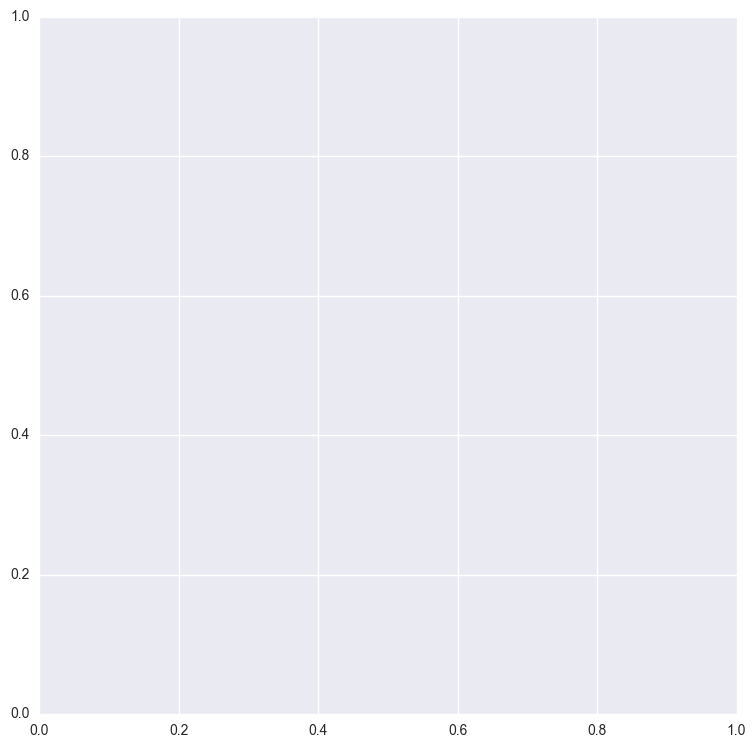

In [23]:
plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(cor, vmax=.8, square=True)

Create Binary Classifier

In [57]:
mapping_dict = {'loan_status':{'Fully Paid':1,'Charged Off': 0,'Default': 0, 'Current': 1}}
df = df.replace(mapping_dict)
df = df[(df['loan_status'] == 1) | (df['loan_status'] == 0)]

print_data_shape(df)
df.loan_status.value_counts()

No rows: 855969
No cols: 47
[[5000.0 5000.0 4975.0 ' 36 months' 10.65 162.87 'B' 'B2' nan 10 'RENT'
  24000.0 'Verified' 1 'n'
  'https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501'
  'credit_card' 'Computer' '860' 'AZ' 27.65 0.0 'Jan-1985' 1.0 3.0 0.0
  13648.0 83.7 9.0 'f' 861.07 0.0 0.0 0.0 'Jan-2015' 171.62 nan 'Jan-2016'
  0.0 1.0 'INDIVIDUAL' 0.0 nan nan nan 'Dec' '2011']]
Index(['Columns: loan_amnt', 'Columns: funded_amnt',
       'Columns: funded_amnt_inv', 'Columns: term', 'Columns: int_rate',
       'Columns: installment', 'Columns: grade', 'Columns: sub_grade',
       'Columns: emp_title', 'Columns: emp_length', 'Columns: home_ownership',
       'Columns: annual_inc', 'Columns: verification_status',
       'Columns: loan_status', 'Columns: pymnt_plan', 'Columns: url',
       'Columns: purpose', 'Columns: title', 'Columns: zip_code',
       'Columns: addr_state', 'Columns: dti', 'Columns: delinq_2yrs',
       'Columns: earliest_cr_line', 'Columns: inq_last_6

1    809502
0     46467
Name: loan_status, dtype: int64

Handle Missing values

Policy Code, Public Record

In [ ]:
df.policy_code.value_counts()
df.pub_rec.value_counts()
df.pymnt_plan.value_counts()

In [58]:
def show_nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)[:25])
    nulls.columns = ['Null Count']   
    nulls.index.name = 'Feature'
    return nulls

In [60]:
# Dropping last few cols with too many nulls
df.drop(['next_pymnt_d','total_rev_hi_lim','tot_coll_amt','tot_cur_bal','emp_title','last_pymnt_d', \
         'title','collections_12_mths_ex_med','last_credit_pull_d', 'total_acc', 'pub_rec',\
         'policy_code','url','pymnt_plan','earliest_cr_line'], 1, inplace=True)

show_nulls(df)

,Null Count
Feature,
revol_util,446
issue_year,0
zip_code,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0


In [61]:
# drop last few records with nulls
df = df.dropna()
print(df.dtypes.value_counts())
print()

show_nulls(df)
print (df.shape)

float64    18
object     13
int64       1
dtype: int64

(855523, 32)


In [63]:
df.ix[:5,:10]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10,RENT
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,1,RENT
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10,RENT
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10,RENT
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1,RENT
5,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,3,RENT


In [64]:
df.ix[:5,11:20]

,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc
0,Verified,1,credit_card,860,AZ,27.65,0.0,1.0,3.0
1,Source Verified,0,car,309,GA,1.00,0.0,5.0,3.0
2,Not Verified,1,small_business,606,IL,8.72,0.0,2.0,2.0
3,Source Verified,1,other,917,CA,20.00,0.0,1.0,10.0
4,Source Verified,1,other,972,OR,17.94,0.0,0.0,15.0
5,Source Verified,1,wedding,852,AZ,11.20,0.0,3.0,9.0


In [66]:
df.ix[:5,21:40]

,revol_util,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,application_type,acc_now_delinq,issue_month,issue_year
0,83.7,f,861.07,0.00,0.00,0.00,171.62,INDIVIDUAL,0.0,Dec,2011
1,9.4,f,435.17,0.00,117.08,1.11,119.66,INDIVIDUAL,0.0,Dec,2011
2,98.5,f,603.65,0.00,0.00,0.00,649.91,INDIVIDUAL,0.0,Dec,2011
3,21.0,f,2209.33,16.97,0.00,0.00,357.48,INDIVIDUAL,0.0,Dec,2011
4,53.9,f,1009.07,0.00,0.00,0.00,67.79,INDIVIDUAL,0.0,Dec,2011
5,28.3,f,631.38,0.00,0.00,0.00,161.03,INDIVIDUAL,0.0,Dec,2011


In [31]:
print_data_shape(df)

show_nulls(df)

No rows: 855523
No cols: 32
[[5000.0 5000.0 4975.0 ' 36 months' 10.65 162.87 'B' 'B2' 10 'RENT' 24000.0
  'Verified' 1 'credit_card' '860' 'AZ' 27.65 0.0 1.0 3.0 13648.0 83.7 'f'
  861.07 0.0 0.0 0.0 171.62 'INDIVIDUAL' 0.0 'Dec' '2011']]
Index(['Columns: loan_amnt', 'Columns: funded_amnt',
       'Columns: funded_amnt_inv', 'Columns: term', 'Columns: int_rate',
       'Columns: installment', 'Columns: grade', 'Columns: sub_grade',
       'Columns: emp_length', 'Columns: home_ownership', 'Columns: annual_inc',
       'Columns: verification_status', 'Columns: loan_status',
       'Columns: purpose', 'Columns: zip_code', 'Columns: addr_state',
       'Columns: dti', 'Columns: delinq_2yrs', 'Columns: inq_last_6mths',
       'Columns: open_acc', 'Columns: revol_bal', 'Columns: revol_util',
       'Columns: initial_list_status', 'Columns: total_rec_int',
       'Columns: total_rec_late_fee', 'Columns: recoveries',
       'Columns: collection_recovery_fee', 'Columns: last_pymnt_amnt',
      

,Null Count
Feature,
issue_year,0
issue_month,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0


Prepare Data: One hot encode, Scaling, normalise

In [ ]:
df.pymnt_plan.value_counts()

In [67]:
cat_columns = ['home_ownership','verification_status','purpose','term', \
               'grade','sub_grade','initial_list_status','addr_state', \
               'issue_month', 'issue_year','application_type']
dummy_df = pd.get_dummies(df[cat_columns])
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(cat_columns, axis=1)
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,...,issue_year_2008,issue_year_2009,issue_year_2010,issue_year_2011,issue_year_2012,issue_year_2013,issue_year_2014,issue_year_2015,application_type_INDIVIDUAL,application_type_JOINT
0,5000.0,5000.0,4975.0,10.65,162.87,10,24000.0,1,860,27.65,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,2500.0,2500.0,15.27,59.83,1,30000.0,0,309,1.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2400.0,2400.0,2400.0,15.96,84.33,10,12252.0,1,606,8.72,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10000.0,10000.0,10000.0,13.49,339.31,10,49200.0,1,917,20.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3000.0,3000.0,3000.0,12.69,67.79,1,80000.0,1,972,17.94,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [68]:
df['loan_status'].value_counts() / df.shape[0]

1    0.945742
0    0.054258
Name: loan_status, dtype: float64

*Algorithms and Techniques*

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_



In [69]:
filtered_loans = df.head(10000)
filtered_loans.to_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/filtered_loans.csv', index=False)

In [71]:
def compute_metrics(predictions):
    
    predictions = pd.Series(predictions)
    # False positives
    fp_filter = (predictions == 1) & (loans['loan_status'] == 0)
    fp = len(predictions[fp_filter])
    
    # True positives
    tp_filter = (predictions == 1) & (loans['loan_status'] == 1)
    tp = len(predictions[tp_filter])
    
    # False negatives
    fn_filter = (predictions == 0) & (loans['loan_status'] == 1)
    fn = len(predictions[fn_filter])
    
    # True negatives
    tn_filter = (predictions == 0)& (loans['loan_status'] == 0)
    tn = len(predictions[tn_filter])
    
    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    print(tpr * 100)
    print(fpr * 100)
    print()
    
    print('Other Mesurements:')
    
    
    sp = tn / (tn + fp)
    sty = tp / (tp + fn)
    G_mean = np.sqrt(sp * sty)
    prcn = tp / (tp + fp)
    acc = (tn + tp) / features.shape[0]
    method_dict = {'specificity': '{:.2f}'.format(sp*100), 
               'sensitivity': '{:.2f}'.format(sty*100), 
               'G-mean': '{:.2f}'.format(G_mean*100),
               'precision': '{:.2f}'.format(prcn*100), 
               'accuracy': '{:.2f}'.format(acc*100),
               'False Positive Rate': '{:.2f}'.format(fpr*100)
              }
    return pd.DataFrame(method_dict,index=['values'])

In [72]:
x_cols = filtered_loans.columns
features_cols = x_cols.drop(['loan_status']) # Dropping target field
features = filtered_loans[features_cols]
target = filtered_loans['loan_status']

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_predict, KFold

scaler = StandardScaler()

In [80]:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    features, target, random_state=42, test_size=.25)

In [101]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
dt = DecisionTreeClassifier(random_state=0)

model = lr.fit(X_train, y_train)
model2 = dt.fit(X_train, y_train)

ValueError: Unknown label type: array([[1],
       [1],
       [1],
       ..., 
       [0],
       [1],
       [0]], dtype=object)

In [93]:
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.175188188444


In [94]:
from sklearn.metrics import classification_report

print ('\nReport for {}:\n'.format(lr.__class__.__name__))
print (classification_report(y_test, lr.predict(X_test)))


Report for LinearRegression:



ValueError: Mix type of y not allowed, got types {'unknown', 'continuous'}

In [87]:
lr = LogisticRegression()
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target, cv=kf) 

# Let's compute performance:
metrics = compute_metrics(predictions)
metrics

ValueError: Unknown label type: array([1, 1, 1, ..., 1, 1, 1], dtype=object)

*Benchmark*

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


**III. Methodology**

*Data Preprocessing*

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


*Implementation*

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_



*Refinement*

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



** IV. Results **

*Model Evaluation and Validation*

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


*Justification*

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

**V. Conclusion**

Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_
